<a href="https://colab.research.google.com/github/jpsiegel/Projects/blob/master/Feudal_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib
from pylab import *
from IPython import display
import time
import numpy as np
from random import uniform, seed

In [ ]:
# Parameters

vassal_grid_size = 5 # n x n
lord_grid_size = vassal_grid_size - 2
governor_grid_size = lord_grid_size - 1

initial_army_level_min, initial_army_level_max = 0.1, 2  
initial_loyalty_value = 1.0
min_army_growth_rate, max_army_growth_rate = 0.01, 0.1

activity_value = 0.5  # [0,1] higher activity means more probability of attacking
loyalty_decay_rate = 0.01
army_portion_left_on_new_conquest = 0.5
times_stronger_lord = 2 # how many times the army value of a lord has to exceed the ones of his neighbours to attack
times_stronger_gov = 3
loyalty_war_boost = 0.2 #how much loyalty is gained from going to war
conquered_initial_loyalty = 0.4 #how loyal is vassal that was just conquered by a new lord
portion_of_vassal_aid_to_go_to_war = 0.5

In [ ]:
# Classes


class Vassal:  # Vasallo

  def __init__(self, id_, initial_army_level, initial_loyalties_up, coord_x, coord_y):
    self.id_ = id_ #este es su nombre, si conquista mas feudos este se traspasa
    self.coords = (coord_x, coord_y) #coordenadas, inmutables
    self.army_value = initial_army_level
    self.loyalties_up = initial_loyalties_up #dict: {L1: loyalty_value1, L2: l_v2}

  def __repr__(self):
    return "Vassal{} c:{}".format(self.id_, self.coords)


class Lord:  # Señor

  def __init__(self, id_, initial_loyalties_up, initial_loyalties_down, last_army_value=0, last_war_vassals=[], last_war_vassals_out=[]):
    self.id_ = id_
    self.loyalties_up = initial_loyalties_up  # dict: {G1: loyalty_value1, G2: l_v2}
    self.loyalties_down = initial_loyalties_down  # dict: {V1: loyalty_value1, V2: l_v2}
    self.last_war_vassals = last_war_vassals
    self.last_war_vassals_out = last_war_vassals_out
    self.last_army_value = last_army_value
    
  def check_state(self):
    """Function to calculate army value of Lord given its loyalties down, 
    also which vassals would or wouldnt go to war with him. Also calls get_neighbours and returns it"""
    all_vassals = []
    for vassal_id, loyalty in self.loyalties_down.items():
      all_vassals.append(vassal_id)
    all_vassal_coords = find_vassals_by_ids(all_vassals)
    neighbours = self.get_neighbours(all_vassal_coords, all_vassals)
    
    army_value_total = 0
    vassals_in = []
    vassals_out = []
    for x, y in all_vassal_coords:
      current_vassal = vassal_nextconfig[x, y]
      try:
        vassal_loyalty = current_vassal.loyalties_up[self.id_]
        lord_loyalty = self.loyalties_down[current_vassal.id_]
      except KeyError:
        print("no encontramos al lord en el loyalties up de su vasallo")
      if uniform(0, 1) < vassal_loyalty * lord_loyalty: #vassals will go to war depending on his loyalty
        army_value_total += current_vassal.army_value * vassal_loyalty
        vassals_in.append(current_vassal.id_)
      else:
        vassals_out.append(current_vassal.id_)
    self.last_army_value = army_value_total #every time army value is calculated, it is saved to pass as info to gov #BUG: last army value is not updated with this iterations lord conquests
    return army_value_total, list(set(vassals_in)), list(set(vassals_out)), neighbours

  def get_neighbours(self, vassal_coords=None, vassal_ids=None):
    """returns attackable neighbours of lord"""
    if vassal_coords is None or vassal_ids is None: #if params are none, gets required data
      vassal_ids = []
      for vassal_id, loyalty in self.loyalties_down.items():
        vassal_ids.append(vassal_id)
      vassal_coords = find_vassals_by_ids(vassal_ids)
    #AQUI HAY BUG
    neighbour_ids = []
    for x, y in vassal_coords:
      current_vassal = vassal_nextconfig[x, y]
      cross_neighbourhood = [(0, 1), (1, 0), (0, -1), (-1, 0)] #not checking diagonals

      for dx, dy in cross_neighbourhood:
        try:
          current_neighbour = vassal_nextconfig[x + dx, y + dy]
        except IndexError: #skip if coords out of map
          continue
        distance = abs((current_neighbour.coords[0] + current_neighbour.coords[1]) - (current_vassal.coords[0] + current_vassal.coords[1]))
        if distance > 2: #skip if its not direct neighbour (was causing bug when x + dx was 0 + -1)
          continue

        if current_neighbour.id_ in vassal_ids:  # skip if neighbour is vassal of self
          continue
        else: # if it hasnt skipped by now, we have a neighbour cell that is other lord
          lord_id = find_superior_of_inferior(current_neighbour)
          neighbour_ids.append(lord_id)
      
    return list(set(neighbour_ids))

  def __repr__(self):
    return "Lord{} l_down:{}".format(self.id_, self.loyalties_down)


class Governor:  # Gobernador

  def __init__(self, id_, initial_loyalties_down):
    self.id_ = id_
    self.loyalties_down = initial_loyalties_down  # dict: {L1: loyalty_value1, L2: l_v2}
    self.last_war_lords = [] #ids of last lords who went with him to war
    self.last_war_lords_out = [] #didnt go
    
  def check_state(self):
    """Function to calculate army value of Governor given its loyalties down, 
    also which lords would or wouldnt go to war with him. Also calls get_neighbours and returns it"""
    all_lords = []
    for lord_id, loyalty in self.loyalties_down.items():
      all_lords.append(lord_id)
    all_lord_coords = find_lords_by_ids(all_lords)
    neighbours = self.get_neighbours(all_lord_coords, all_lords)
    
    army_value_total = 0
    lords_in = []
    lords_out = []
    for x, y in all_lord_coords:
      current_lord = lord_nextconfig[x, y]
      try:
        lord_loyalty = current_lord.loyalties_up[self.id_]
        gov_loyalty = self.loyalties_down[current_lord.id_]
      except KeyError:
        print("no encontramos al governor en el loyalties up de su lord")
      if uniform(0, 1) < lord_loyalty * gov_loyalty: #lords will go to war depending on his loyalty
        army_value_total += current_lord.last_army_value * lord_loyalty
        lords_in.append(current_lord.id_)
      else:
        lords_out.append(current_lord.id_)
    return army_value_total, list(set(lords_in)), list(set(lords_out)), neighbours

  def get_neighbours(self, lord_coords, lord_ids):
    """returns attackable neighbours of gov"""
    lord_neighbour_ids = []
    for x, y in lord_coords: #find all neighbours of lords of this gov
      current_lord = lord_nextconfig[x, y]
      current_lord_neighbours = current_lord.get_neighbours()
      lord_neighbour_ids.extend(current_lord_neighbours)

    gov_nieghbours_ids = []
    for lord_id in list(set(lord_neighbour_ids)):
      if lord_id in lord_ids: #is also lord of self
        continue
      else: #this lord is of enemy governor, therefore that governor is neighbour
        lord = find_lord_by_id(lord_id)
        gov_id = find_superior_of_inferior(lord)
        gov_nieghbours_ids.append(gov_id)

    return list(set(gov_nieghbours_ids))

  def __repr__(self):
    return "Governor{} l_down:{}".format(self.id_, self.loyalties_down)

In [ ]:
#Auxiliar functions

def connect_down(A, B, value=initial_loyalty_value):
  """Connects A down to B. A will have a loyalties_down pointing to B.
  B will have a loyalties_up pointing to A"""
  A.loyalties_down[B.id_] = value
  B.loyalties_up[A.id_] = value

def disconnect_down(superior, inferior):
  """Disconnects superior from inferior and vice versa. 
  Superior will no longer have a loyalties_down pointing to inferior.
  Inferior will no longer have a loyalties_up pointing to superior."""
  try:
    del superior.loyalties_down[inferior.id_]
  except KeyError:
    pass
  try:
    del inferior.loyalties_up[superior.id_]
  except KeyError:
    pass

  assert inferior.id_ not in superior.loyalties_down.keys()
  assert superior.id_ not in inferior.loyalties_up.keys()

def connect_all():
  """ Given a grid size, this generates random valid starting conditions for the connections"""
  pass

def print_connections(vassal_config, lord_config, governor_config):
    print("Vassal Config:")
    print(vassal_config)
    print("")
    print("Lord Config:")
    print(lord_config)
    print("")
    print("Governor Config:")
    print(governor_config)
    print("")

def find_superior_of_inferior(inferior):
  """ Given a (inferior) vassal/lord object, returns the (superior) lord/gover object.id_ connected with him """
  superior_id = list(inferior.loyalties_up.keys())[0]  # id of first superior connected, but

  if len(inferior.loyalties_up.keys()) > 1: #if he has more than one connection, choose most loyal
    most_loyal = max(inferior.loyalties_up.values())
    for id__, value in inferior.loyalties_up.items():
      if value == most_loyal:
        superior_id = id__
        break
  return superior_id

def find_lord_of_vassal(vassal):
  """ Given a vassal object, returns the lord object connected with him """
  lord_id = list(vassal.loyalties_up.keys())[0]  # id of first lord connected, but

  if len(vassal.loyalties_up.keys()) > 1: #if he has more than one connection, choose most loyal
    most_loyal = max(vassal.loyalties_up.values())
    for id__, value in vassal.loyalties_up.items():
      if value == most_loyal:
        lord_id = id__
        break

  target_lord = None
  for x in range(lord_grid_size):
    for y in range(lord_grid_size):
      if lord_config[x,y].id_ == lord_id:
        target_lord = lord_config[x,y]
        return target_lord
  if target_lord == None:
    raise ValueError("Vassal's lord not found in lord_config")

def find_lord_by_id(id_):
  """ Given a id, returns the lord object of that id"""
  target_lord = None
  for x in range(lord_grid_size):
    for y in range(lord_grid_size):
      if lord_nextconfig[x,y].id_ == id_:
        target_lord = lord_nextconfig[x,y]
        return target_lord
  if target_lord == None:
    raise ValueError("Lord not found in nextlord_config")

def find_governor_by_id(id_, config):
  """ Given a id, returns the governor object of that id"""
  if config == "nextconfig":
    target_gov = None
    for x in range(governor_grid_size):
      for y in range(governor_grid_size):
        if governor_nextconfig[x,y].id_ == id_:
          target_gov = governor_nextconfig[x,y]
          return target_gov
    if target_gov == None:
      raise ValueError("Governor not found in nextconfig_governor")

  elif config == "config":
    target_gov = None
    for x in range(governor_grid_size):
      for y in range(governor_grid_size):
        if governor_config[x,y].id_ == id_:
          target_gov = governor_config[x,y]
          return target_gov
    if target_gov == None:
      raise ValueError("Governor not found in nextconfig_governor")
  else:
    raise ValueError("must be config or nextconfig")

def find_governor_of_vassal(vassal):
  """ Given a vassal object, returns the governor object connected with him through a lord"""
  lord = find_lord_of_vassal(vassal)
  governor_id = list(lord.loyalties_up.keys())[0]  # id of first governor connected # considerar mas de un gov
  target_governor = None
  for x in range(governor_grid_size):
    for y in range(governor_grid_size):
      if governor_config[x, y].id_ == governor_id:
        target_governor = governor_config[x, y]
        return target_governor
  if target_governor == None:
    raise ValueError("Vassal's governor not found in governor_config")

def find_vassals_by_ids(vassal_id_list):
  """given a list of vassal ids, returns tuple list of the 
  coordinates of all vassal cells that have one of those ids"""
  vassal_coords = []
  for x in range(vassal_grid_size):
    for y in range(vassal_grid_size):
      if vassal_nextconfig[x,y].id_ in vassal_id_list:
        vassal_coords.append((x, y))
  return vassal_coords

def find_lords_by_ids(lord_id_list):
  """given a list of lord ids, returns tuple list of the 
  coordinates of all lord cells that have one of those ids"""
  lord_coords = []
  for x in range(lord_grid_size):
    for y in range(lord_grid_size):
      if lord_nextconfig[x,y].id_ in lord_id_list:
        lord_coords.append((x, y))
  return lord_coords

def clean_hitmap(hitmap):
  """If hitmap colision exists, will cause error because same inferior object 
  will be disconnected mroe than once, leaving him no loyalties_up.
  This function removes duplicates at random, so only one attacker hits every target"""
  d1 = hitmap
  clean_hitmap = {}
 
  for k, v in d1.items():
    if v not in clean_hitmap.values():
      clean_hitmap[k] = v

  return clean_hitmap

In [ ]:
# backend

def initialize(pattern=1, printy=False):
    global vassal_config, vassal_nextconfig, lord_config, lord_nextconfig, governor_config, governor_nextconfig, all_vassals, all_lords, all_governors
    seed(pattern)  # if uncommented, all executions give same pattern of army values

    #initialize vassal level
    vassal_config = np.zeros([vassal_grid_size, vassal_grid_size], dtype=type(Vassal(None, 1, {}, -1, -1)))

    id_counter = 1
    for x in range(vassal_grid_size):
      for y in range(vassal_grid_size):
        initial_army_level = round(uniform(initial_army_level_min, initial_army_level_max), 3)
        new_vassal = Vassal(id_counter, initial_army_level, {}, x, y)
        vassal_config[x, y] = new_vassal
        id_counter += 1

    vassal_nextconfig = np.zeros([vassal_grid_size, vassal_grid_size], dtype=type(Vassal(None, 1, {}, -1, -1)))

    #initialize lord level
    lord_config = np.zeros([lord_grid_size, lord_grid_size], dtype=type(Lord(None, {}, {})))

    id_counter = 1
    for x in range(lord_grid_size):
      for y in range(lord_grid_size):
        new_lord = Lord(id_counter, {}, {})
        lord_config[x, y] = new_lord
        id_counter += 1

    lord_nextconfig = np.zeros([lord_grid_size, lord_grid_size], dtype=type(Lord(None, {}, {})))

    #initialize governor level
    governor_config = np.zeros([governor_grid_size, governor_grid_size], dtype=type(Governor(None, {})))

    id_counter = 1
    for x in range(governor_grid_size):
      for y in range(governor_grid_size):
        new_governor = Governor(id_counter, {})
        governor_config[x, y] = new_governor
        id_counter += 1

    governor_nextconfig = np.zeros([governor_grid_size, governor_grid_size], dtype=type(Governor(None, {})))

    #connect all levels (random initial condition (WIP))
    #connect_all()
    
    #connect all levels (deterministic initial condition)
    #connect govs
    #1st gov
    connect_down(governor_config[0,0], lord_config[0, 0])
    connect_down(governor_config[0,0], lord_config[1, 0])
    #2nd gov
    connect_down(governor_config[0,1], lord_config[0, 1])
    connect_down(governor_config[0,1], lord_config[0, 2])
    #3rd gov
    connect_down(governor_config[1,0], lord_config[1, 1])
    connect_down(governor_config[1,0], lord_config[1, 2])
    connect_down(governor_config[1,0], lord_config[2, 2])
    #4th gov
    connect_down(governor_config[1,1], lord_config[2, 0])
    connect_down(governor_config[1,1], lord_config[2, 1])
    
    #connect lords
    #1st lord
    connect_down(lord_config[0,0], vassal_config[0, 0])
    connect_down(lord_config[0,0], vassal_config[1, 0])
    connect_down(lord_config[0,0], vassal_config[0, 1])
    #2do lord
    connect_down(lord_config[0,1], vassal_config[0, 2])
    connect_down(lord_config[0,1], vassal_config[1, 2])
    connect_down(lord_config[0,1], vassal_config[0, 3])
    #3rd lord
    connect_down(lord_config[0,2], vassal_config[1, 3])
    connect_down(lord_config[0,2], vassal_config[0, 4])
    connect_down(lord_config[0,2], vassal_config[1, 4])
    connect_down(lord_config[0,2], vassal_config[2, 4])
    #4th lord
    connect_down(lord_config[1,0], vassal_config[2, 0])
    connect_down(lord_config[1,0], vassal_config[1, 1])
    connect_down(lord_config[1,0], vassal_config[2, 1])
    #5th lord
    connect_down(lord_config[1,1], vassal_config[2, 2])
    connect_down(lord_config[1,1], vassal_config[3, 2])
    connect_down(lord_config[1,1], vassal_config[2, 3])
    #6th lord
    connect_down(lord_config[1,2], vassal_config[3, 3])
    connect_down(lord_config[1,2], vassal_config[3, 4])
    connect_down(lord_config[1,2], vassal_config[4, 4])
    #7th lord
    connect_down(lord_config[2,0], vassal_config[3, 0])
    connect_down(lord_config[2,0], vassal_config[4, 0])
    #8th lord
    connect_down(lord_config[2,1], vassal_config[3, 1])
    connect_down(lord_config[2,1], vassal_config[4, 1])
    #9th lord
    connect_down(lord_config[2,2], vassal_config[4, 2])
    connect_down(lord_config[2,2], vassal_config[4, 3])

    if printy:
      print_connections(vassal_config, lord_config, governor_config)


def observe(year, ca_level, color_map):
    global vassal_config, vassal_nextconfig, lord_config, lord_nextconfig, governor_config, governor_nextconfig
    cla()
    if ca_level == "vassal":  # plot vassal level
      aux_config = np.zeros([vassal_grid_size, vassal_grid_size])
      for x in range(vassal_grid_size):
        for y in range(vassal_grid_size):
          aux_config[x,y] = vassal_config[x,y].id_ #cambia instancia por id
      
    if ca_level == "lord":  # plot lord level
      aux_config = np.zeros([vassal_grid_size, vassal_grid_size])
      for x in range(vassal_grid_size):
        for y in range(vassal_grid_size): 
          # cambia instancia de vassal por id del primer lord conectado
          # normalizamos para usar toda la escala de colores
          lord_id = find_lord_of_vassal(vassal_config[x,y]).id_
          normalized_id = (vassal_grid_size / lord_grid_size) * (lord_id - 1)
          aux_config[x,y] = normalized_id  

    if ca_level == "governor":  # plot governor level
      aux_config = np.zeros([vassal_grid_size, vassal_grid_size])
      for x in range(vassal_grid_size):
        for y in range(vassal_grid_size):
          # cambia instancia de vassal por id del primer gov conectado
          # normalizamos para usar toda la escala de colores
          gov_id = find_governor_of_vassal(vassal_config[x,y]).id_
          normalized_id = (vassal_grid_size / governor_grid_size) * (gov_id - 1) 
          aux_config[x,y] = normalized_id  

    imshow(aux_config, vmin = 0, vmax = vassal_grid_size * vassal_grid_size, cmap = color_map)
    #print_connections(vassal_config, lord_config, governor_config)

def update(printy=False):
  """ First we update army_value and loyalties for all vassals/lords/govs, then we generate decisions/actions for gov,lord,vassal """
  global vassal_config, vassal_nextconfig, lord_config, lord_nextconfig, governor_config, governor_nextconfig

  vassal_hitmap = {}  # {attacker_coords: target_coords}
  # iterate through VASSAL grid
  for x in range(vassal_grid_size):
    for y in range(vassal_grid_size):
      # update grid with new values
      current_vassal = vassal_config[x, y]
      growth_factor = 1 + uniform(min_army_growth_rate, max_army_growth_rate)  # in each step army value grows
      updated_army_value = round(current_vassal.army_value * growth_factor, 3)
      updated_loyalties = {k: v * (1 - loyalty_decay_rate) for k, v in current_vassal.loyalties_up.items()}  # in each step loyalty decays
      vassal_nextconfig[x, y] = Vassal(current_vassal.id_, updated_army_value, updated_loyalties, x, y)
      current_vassal = vassal_nextconfig[x, y]

      if uniform(0,1) > activity_value: #some chance to skip vassal #should change to exitation system (wont attack if attacked last)
        continue

      # iterate through neighbourhood
      neighbours_army_values = {}  # coords: value
      aux_army_values = {} # id: value, es para sumar los del mismo id
      for dx in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
          try:
            current_neighbour = vassal_config[x + dx, y + dy]
          except IndexError: #skip if coords out of map
            continue

          distance = abs((current_neighbour.coords[0] + current_neighbour.coords[1]) - (current_vassal.coords[0] + current_vassal.coords[1]))
          if distance > 2: #skip if its not direct neighbour (was causing bug when x + dx was 0 + -1)
            continue

          if current_neighbour.id_ != current_vassal.id_:  # skip if self
            try:
              neighbours_army_values[current_neighbour.coords] += current_neighbour.army_value
              aux_army_values[current_neighbour.id_] += current_neighbour.army_value
            except KeyError:
              neighbours_army_values[current_neighbour.coords] = current_neighbour.army_value
              aux_army_values[current_neighbour.id_] = current_neighbour.army_value

      # vassal attack rules
      if len(neighbours_army_values) > 0 and current_vassal.army_value >= max(aux_army_values.values()):  # if stronger than neighbours (added by ids)
        target_vassal_coords = min(neighbours_army_values.keys(), key=(lambda k: neighbours_army_values[k]))  # attacks weakest neighbour
        vassal_hitmap[current_vassal.coords] = target_vassal_coords

  clean_vassal_hitmap = clean_hitmap(vassal_hitmap) #eliminate target colissions
  if printy:
    print("Hitmap")
    print(clean_vassal_hitmap)
  
  # after all attacks are checked (all vassals are in nextconfig)
  # consequences of vassal attacks
  for attacker_coords, target_coords in clean_vassal_hitmap.items():
    attacker = vassal_nextconfig[attacker_coords[0], attacker_coords[1]]
    target = vassal_nextconfig[target_coords[0], target_coords[1]]
    target.id_ = attacker.id_
    target.loyalties_up = {k: v for k, v in attacker.loyalties_up.items()} #loyalties are passed to conqueror

  # iterate through LORD grid ##################################################
  lords_army_values = {}  # id: value
  lords_neighbourhood = {} # id: ids (if lord neighbourhood is empty, lord was defeated)
  for x in range(lord_grid_size):
    for y in range(lord_grid_size):
      current_lord = lord_config[x, y]
      updated_loyalties_up = {k: v * (1 - loyalty_decay_rate) for k, v in current_lord.loyalties_up.items()}  # in each step loyalty decays by loyalty_decay_rate
      updated_loyalties_down = {k: v * (1 - loyalty_decay_rate) for k, v in current_lord.loyalties_down.items()}
      lord_nextconfig[x, y] = Lord(current_lord.id_, updated_loyalties_up, updated_loyalties_down, 
                                   current_lord.last_army_value, current_lord.last_war_vassals, 
                                   current_lord.last_war_vassals_out)
      current_lord = lord_nextconfig[x, y]

      #lord checks his state (calcualtes army value and neighbours)
      current_army_value, vassals_in, vassals_out, neighbour_ids = current_lord.check_state()
      current_lord.last_war_vassals = vassals_in # lord remembers who aided him in war
      current_lord.last_war_vassals_out = vassals_out
      lords_army_values[current_lord.id_] = current_army_value
      lords_neighbourhood[current_lord.id_] = neighbour_ids

  #iterate again so all army values and neighbourhoods are already updated 
  lord_hitmap = {}  
  for x in range(lord_grid_size):
    for y in range(lord_grid_size):
      current_lord = lord_nextconfig[x, y]
      current_neighbours = lords_neighbourhood[current_lord.id_]
      current_army_value = lords_army_values[current_lord.id_]
      current_neighbours_army_values = {id__: lords_army_values[id__] for id__ in current_neighbours}

      #lord attack rules
      if len(current_neighbours) > 0 and current_army_value >= times_stronger_lord * max(current_neighbours_army_values.values()):  # if times_stronger than neighbours
        if True: #len(current_lord.last_war_vassals) > len(current_lord.last_war_vassals_out): # only attacks if majority of vassals aids him
          target_lord_id = min(current_neighbours_army_values.keys(), key=(lambda k: current_neighbours_army_values[k]))  # attacks weakest neighbour
          lord_hitmap[current_lord.id_] = target_lord_id
          for vassal_id in current_lord.last_war_vassals:
            current_lord.loyalties_down[vassal_id] = max(1, current_lord.loyalties_down[vassal_id] + loyalty_war_boost) #loyalty is boosted for aiding in war
            #bug: should update vassal loyalty up
            #bug: if hitmap collision occurs, loyalty will be boosted even tho no conquest was made

  clean_lord_hitmap = clean_hitmap(lord_hitmap) #eliminate target colissions
  if printy:
    #print("Army Values Lords: ", lords_army_values)
    print("Neighbours Lords: ", lords_neighbourhood)
    print("Lord Hitmap: ", clean_lord_hitmap)

  #consequences of lord attacking
  for attacker_id, target_id in clean_lord_hitmap.items():
    if attacker_id == target_id:
      raise NameError("governor selected himself as target")
    attacker = find_lord_by_id(attacker_id)
    target = find_lord_by_id(target_id)
    target_governor_id = find_superior_of_inferior(target)
    target_governor = find_governor_by_id(target_governor_id, config="config")
    disconnect_down(target_governor, target) #since lord is defeated, governor no longer has him as lord

    #iterate through target vassals and pass them to attacker
    vassals_to_disconnect = []
    for vassal_id in target.loyalties_down.keys():
      vassals_coords = find_vassals_by_ids([vassal_id])
      for vassal_coord_x, vassal_coord_y in vassals_coords:
        vassal_ = vassal_nextconfig[vassal_coord_x, vassal_coord_y]
        connect_down(attacker, vassal_, conquered_initial_loyalty) #attacker and vassal are connected
        vassals_to_disconnect.append(vassal_)
    for vassal__ in vassals_to_disconnect:
      disconnect_down(target, vassal__) # and each vassal is no longer loyal to defeated lord


  # iterate through GOVERNOR grid ##############################################
  govs_army_values = {}  # id: value
  govs_neighbourhood = {} # id: ids (if governor neighbourhood is empty, governor was defeated)
  for x in range(governor_grid_size):
    for y in range(governor_grid_size):
      current_gov = governor_config[x, y]
      updated_loyalties_down = {k: v * (1 - loyalty_decay_rate) for k, v in current_gov.loyalties_down.items()}
      governor_nextconfig[x, y] = Governor(current_gov.id_, updated_loyalties_down)
      current_gov = governor_nextconfig[x, y]

      #gov checks his state (calcualtes army value and neighbours)
      current_army_value, lords_in, lords_out, neighbour_ids = current_gov.check_state()
      current_gov.last_war_lords = lords_in # gov remembers who aided him in war
      current_gov.last_war_lords_out = lords_out
      govs_army_values[current_gov.id_] = current_army_value
      govs_neighbourhood[current_gov.id_] = neighbour_ids

  #iterate again so all army values and neighbourhoods are already updated 
  gov_hitmap = {}  
  for x in range(governor_grid_size):
    for y in range(governor_grid_size):
      current_gov = governor_nextconfig[x, y]
      current_neighbours = govs_neighbourhood[current_gov.id_]
      current_army_value = govs_army_values[current_gov.id_]
      current_neighbours_army_values = {id__: govs_army_values[id__] for id__ in current_neighbours}

      #gov attack rules
      if len(current_neighbours) > 0 and current_army_value >= times_stronger_gov * max(current_neighbours_army_values.values()):  # if times_stronger than neighbours
        if True: #len(current_lord.last_war_vassals) > len(current_lord.last_war_vassals_out): # only attacks if majority of vassals aids him
          target_gov_id = min(current_neighbours_army_values.keys(), key=(lambda k: current_neighbours_army_values[k]))  # attacks weakest neighbour
          gov_hitmap[current_gov.id_] = target_gov_id
          for lord_id in current_gov.last_war_lords:
            current_gov.loyalties_down[lord_id] = max(1, current_gov.loyalties_down[lord_id] + loyalty_war_boost) #loyalty is boosted for aiding in war
            #bug: should update lord loyalty up
            #bug: if hitmap collision occurs, loyalty will be boosted even though no conquest was made

  clean_gov_hitmap = clean_hitmap(gov_hitmap)
  if printy:
    #print("Army Values Govs: ", govs_army_values)
    print("Neighbours Govs: ", govs_neighbourhood)
    print("Govs Hitmap: ", clean_gov_hitmap)

  #consequences of governor attacking
  for attacker_id, target_id in clean_gov_hitmap.items():
    if attacker_id == target_id:
      raise NameError("governor selected himself as target")
    attacker = find_governor_by_id(attacker_id, config="nextconfig")
    target = find_governor_by_id(target_id, config="nextconfig")

    lords_to_disconnect = []
    for lord_id in target.loyalties_down.keys():
      affected_lord = find_lord_by_id(lord_id)
      connect_down(attacker, affected_lord, conquered_initial_loyalty) #gov attacker and lord are connected
      lords_to_disconnect.append(affected_lord)
    for lord__ in lords_to_disconnect:
      disconnect_down(target, lord__) # and each lord is no longer loyal to defeated gov

  #reset for next iteration
  vassal_config, vassal_nextconfig = vassal_nextconfig, vassal_config
  lord_config, lord_nextconfig = lord_nextconfig, lord_config
  governor_config, governor_nextconfig = governor_nextconfig, governor_config

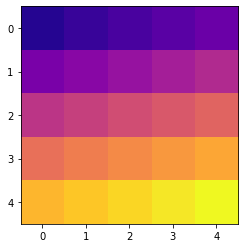

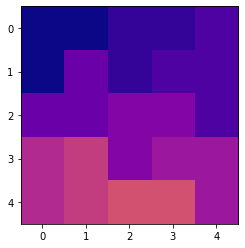

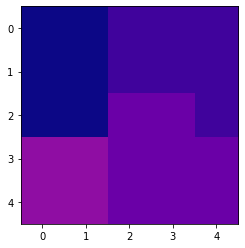

In [ ]:
#main

# Simulate and plot results
nice_patterns = [(10, "pugna pasa a control absoluto"), (17, ""), (18, ""), (22, "")]
init_pattern = 10 # input("Initial Pattern?: ")

for p in range(int(init_pattern), 40):

  initialize(pattern=p, printy=False)
  for year in range(1):
      print("Pattern: {}; Year: {}".format(p, year))
      update(printy=False)
      observe(year, ca_level="vassal", color_map="plasma")
      display.display(gcf())
      observe(year, ca_level="lord", color_map="plasma")
      display.display(gcf())
      observe(year, ca_level="governor", color_map="plasma")
      display.display(gcf())
      time.sleep(0.9)
      display.clear_output(wait=True) #comment for whole output
      plt.close()
  plt.show()

  inp = input("Simulate next pattern?: y/n ").lower()
  if inp != "y":
    break

